In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
import os
import pickle
import importlib
import detect_bursts
importlib.reload(detect_bursts)
import copy
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans

from collections import defaultdict

Loading ALdata

In [8]:
def convertIntoFloatList(str):
    #preprocess data extracted
    #remove the "[" and "]" characters
    str = str[1:-1]
    if str == '':
        return None
    return np.array(str.split(','),dtype = float)

def readData(frame,mothName):
    #convert dataframe rows into an entire list
    tp = []
    nameArr = []
    for ind in frame.index:
        inc = convertIntoFloatList(frame[ind])
        if inc is not None:
            tp.append(inc)
            nameArr.append(mothName)
    return tp,nameArr

#load xlsx data, extract column with largest pre_stim
def argMaxPreStim(mothNum):

    dir = os.getcwd()
    #load data from csv file
    loadPath =  os.path.join(dir,f'ALdata/timestamps_{mothNum}.csv')

    df = pd.read_csv(loadPath,header=0)

    argMaxColName = df.columns[np.argmax(df.iloc[0][2:]) + 2]
    print(f"##########current stimuli referenced: {argMaxColName}##########")
    return argMaxColName

#load csv data, extract timestamps
def loadData(mothNum):

    dir = os.getcwd()
    #load data from csv file
    loadPath =  os.path.join(dir,f'ALdata/{mothNum}_pre_stim_cleaned.csv')

    df = pd.read_csv(loadPath, header = 0)
    
    
    #take samples with stimuli giving largest pre_stim value in first row
    Df = df.loc[df['stimuli'] == argMaxPreStim(mothNum)]
    

    tempDf = []
    tempName = []

    neuronCols = list(Df.columns[3:])
    for neuron in neuronCols:
        curArr,nameArr = readData(Df[neuron],mothNum)
        tempDf += curArr
        tempName += nameArr

    #add an entire column of mothNums at the end of tempDf
    #tempDf = np.array(tempDf)
    #mothNums = np.full((tempDf.shape[0],1),mothNum)
    #tempDf = np.concatenate((tempDf,mothNums),axis = 1)
    print(tempName)

    return tempDf,tempName

Derive Nine Parameters

In [9]:
#within-burst number of spikes
def withinBurstNumSpikes(burstIndicator):
    num = len(np.where(burstIndicator == 1)[0])
    percentage = num/burstIndicator.shape[0]
    return num,percentage

#burst duration and inter-burst interval
def durations(timestamps,finalBurstRanges):
    burst = timestamps[finalBurstRanges[0][1]] - timestamps[finalBurstRanges[0][0]]
    #here we assume interBurst doesn't include the start-first-burst interval or the last-burst-end interval
    interBurstSt = finalBurstRanges[0][1]
    interBurst = 0

    maxSpikingFreq = (finalBurstRanges[0][1] - finalBurstRanges[0][0] + 1)/burst

    #tuple representing current burst
    for tup in finalBurstRanges[1:]:
        burstInc = timestamps[tup[1]] - timestamps[tup[0]]
        burst += burstInc
        interBurst += timestamps[tup[0]] - timestamps[interBurstSt]
        interBurstSt = tup[1]

        #count spikes within current burst
        curSpikingFreq = (tup[1]-tup[0]+1)/burstInc
        if maxSpikingFreq < curSpikingFreq:
            maxSpikingFreq = curSpikingFreq

    return burst,interBurst,maxSpikingFreq

#within-burst spiking frequency
def meanSpikingFreq(num,duration):
    return num/duration

#surprise values
def surpriseEval(finalBurstSurprises):
    meanSurprise = np.mean(finalBurstSurprises)
    maxSurprise = np.max(finalBurstSurprises)
    return meanSurprise,maxSurprise

#mean burst frequency
def meanBurstFreq(finalNumBursts,totalTime):
    meanburstFreq = finalNumBursts/totalTime
    return meanburstFreq

#render 9 parameters for each sample (1 trial of 1 neuron)
def renderParams(timestamps,finalBurstRanges,finalBurstSurprises,burstIndicator,finalNumBursts,totalTime):
    withinBurstSpikeNum,withinBurstSpikePercentage = withinBurstNumSpikes(burstIndicator)
    duration,interBurst,maxSpikingFreq = durations(timestamps,finalBurstRanges)
    meanSpikingFreq = withinBurstSpikeNum/duration
    meanSurprise,maxSurprise = surpriseEval(finalBurstSurprises)
    meanburstFreq = meanBurstFreq(finalNumBursts,totalTime)
    return [duration,meanSpikingFreq,maxSpikingFreq,withinBurstSpikeNum,\
            interBurst,withinBurstSpikePercentage,meanburstFreq,meanSurprise,maxSurprise]

#start collecting data for logistic regression
def collectModelData(mothNames):
    #for each moth, for each trial, for each neuron, render 9 parameters
    totalDf = []
    totalName = []
    for mothName in mothNames:
        mothDf,mothNameArr = loadData(mothName)
        print(f"########current number of rows: {len(mothDf)}########")
        totalDf += mothDf
        totalName += mothNameArr
    
    print("############all data loaded############")
    #print row number of totalDf
    print(f"############totalDf row number{len(totalDf)}############")

    return totalDf,totalName

def formulateDataset(totalDf,totalName):
    sampleDataset = []
    nameRes = []
    for index,dfRow in enumerate(totalDf):
        lInput = [0] + dfRow
        burstIndicator,finalNumBursts,finalBurstRanges,finalBurstSurprises,totalTime = detect_bursts.detectBursts(lInput,0,math.inf,2)
        if finalBurstRanges != []:
            sampleDataset.append(renderParams(lInput,finalBurstRanges,finalBurstSurprises,burstIndicator,finalNumBursts,totalTime))
            nameRes.append(totalName[index])
    return sampleDataset,nameRes

mothNames = ['070906', '070913', '070921', '070922', '070924_1', '070924_2', '071002']
totalDf,totalName = collectModelData(mothNames)

##########current stimuli referenced: P9_TenThous##########
['070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906']
########current number of rows: 51########
##########current stimuli referenced: M6##########
['070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913']
########current number of rows: 30

In [41]:
#not run if sampleDataset.pkl already exists
#formulate dataset
sampleDataset,nameRes = formulateDataset(totalDf,totalName)

#save sampleDataset
with open('sampleDataset_debug.pkl', 'wb') as f:
    pickle.dump((sampleDataset,nameRes), f)

In [44]:
def extractPickle(filename):
    #extract sampleDataset from pickle file
    with open(filename, 'rb') as f:
        sampleDataset,information,data_no_burst,data_no_burst_I = pickle.load(f)
    
    return sampleDataset,information,data_no_burst,data_no_burst_I

sampleDataset,information,data_no_burst,data_no_burst_I = extractPickle('sampleDataset_refined_4.pkl')


In [45]:
print(np.array(sampleDataset).shape)

(6230, 9)


In [70]:
print(np.array(information))   

[['Bea' 'S1U1' '070906']
 ['Bea' 'S1U1' '070906']
 ['Bol' 'S1U1' '070906']
 ...
 ['M2' 'S3U3' '071002']
 ['M2' 'S3U3' '071002']
 ['M2' 'S3U3' '071002']]


In [23]:
print(np.count_nonzero(np.array(information) == '070906'))
print(np.count_nonzero(np.array(information) == '070913'))
print(np.count_nonzero(np.array(information) == '070921'))
print(np.count_nonzero(np.array(information) == '070922'))
print(np.count_nonzero(np.array(information) == '070924_1'))
print(np.count_nonzero(np.array(information) == '070924_2'))
print(np.count_nonzero(np.array(information) == '071002'))

312
255
862
1442
1114
1171
1074


In [91]:
#check whether a (moth,neuron) pair either has burst or hasn't burst regardless of stimuli
droppedDF = pd.DataFrame(data_no_burst_I)
droppedDF.columns = ['stimuli','neuron','mothName']

print(droppedDF.shape)

(3813, 3)


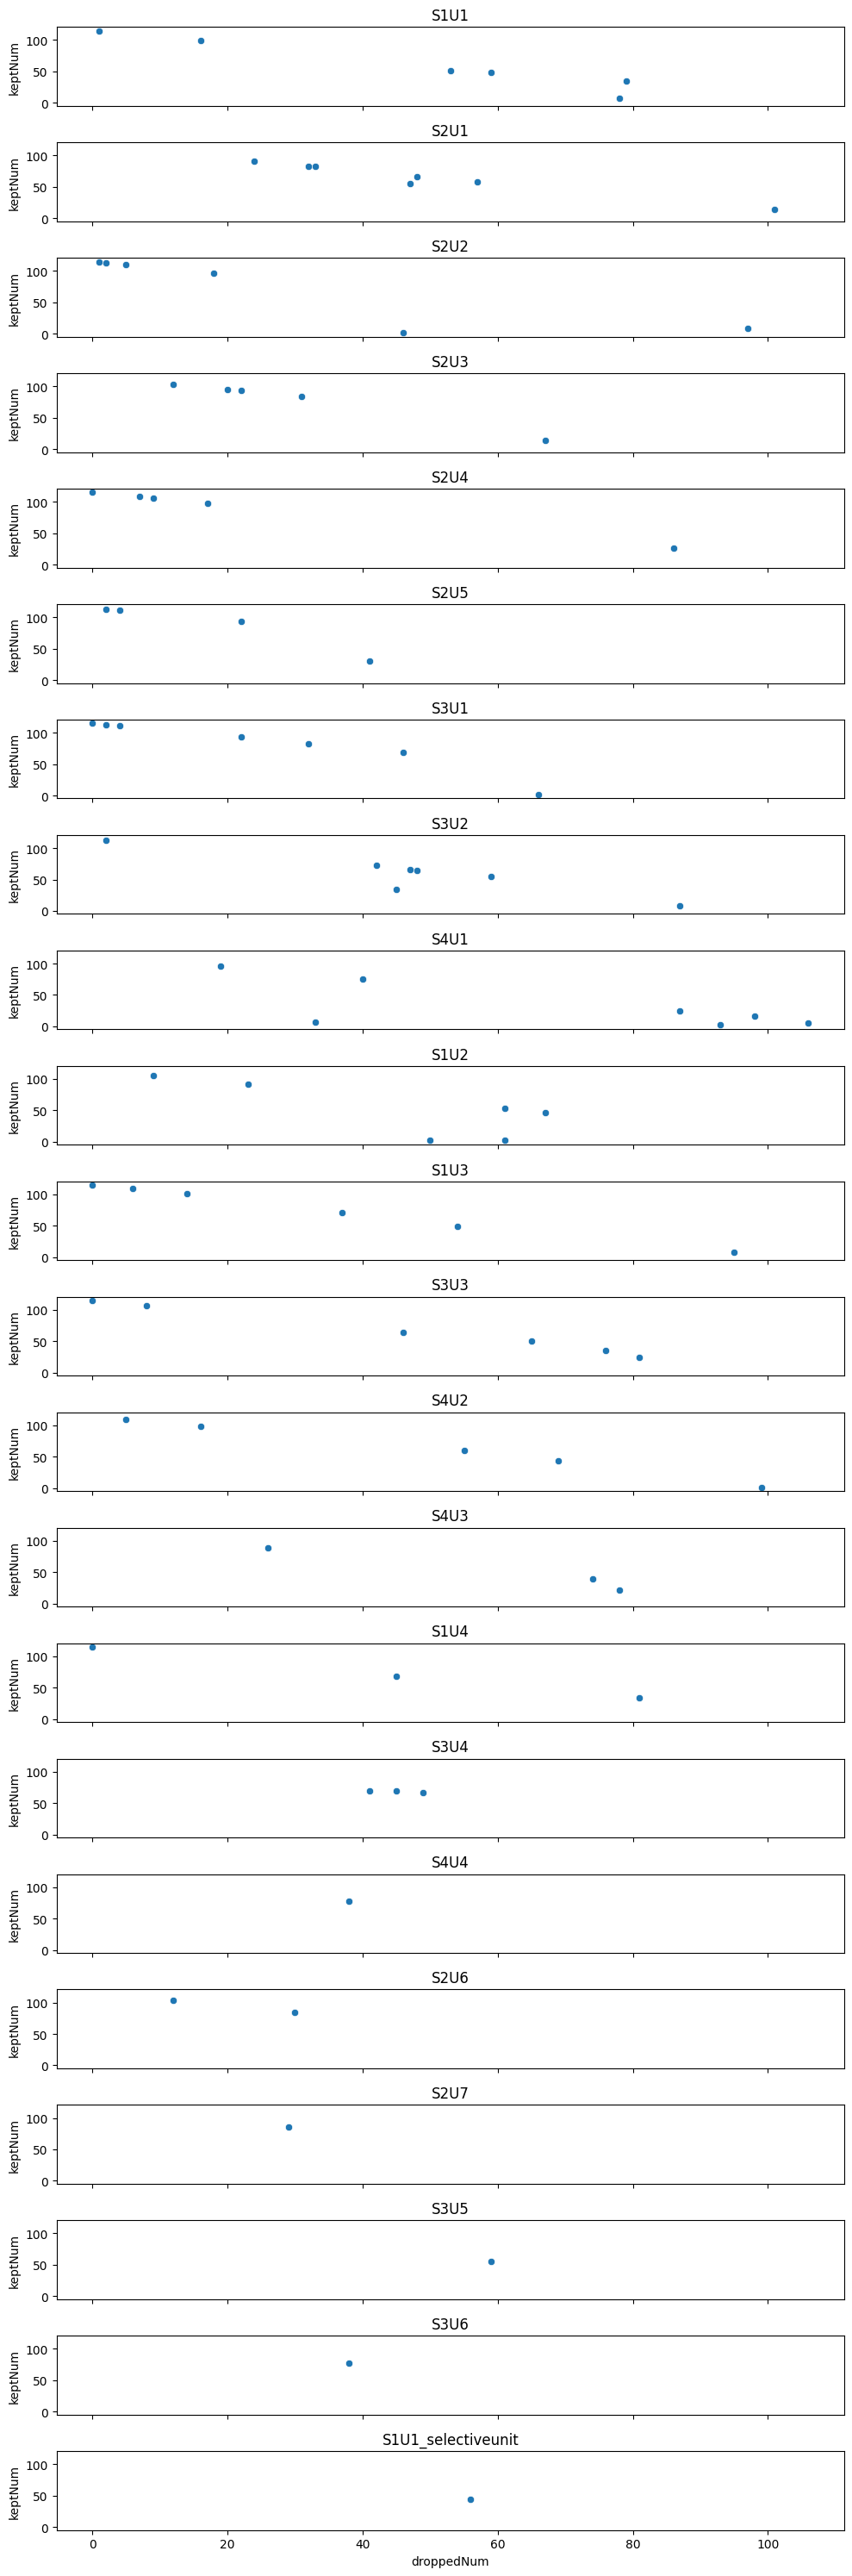

In [90]:
def checkDroppedOrNot(mothNameLst,droppedDF,information):
    #read neuronName from mothName_pre_stim_cleaned.csv
    dir = os.getcwd()
    tmp = defaultdict(lambda: [])
    #load data from csv file
    for mothName in mothNameLst:
        loadPath =  os.path.join(dir,f'ALdata/{mothName}_pre_stim_cleaned.csv')
        csvDF = pd.read_csv(loadPath, header = 0)
        for neuronName in csvDF.columns[3:]:
            #print(f"mothName: {mothName}, neuronName: {neuronName}")
            droppedNum = np.count_nonzero((droppedDF['mothName'] == mothName) \
                                & (droppedDF['neuron'] == neuronName))
            #print(f"droppedNum: {droppedNum}")

            #count number of mothName = 070906 and neuron = S1U1 in information
            keptNum = np.count_nonzero((np.array(information)[:,2] == mothName) \
                                & (np.array(information)[:,1] == neuronName))
            #print(f"keptNum: {keptNum}")
            #print("#############")
            tmp[neuronName] += [[droppedNum,keptNum]]
    return tmp

#check whether given a neuron and a moth name, \
# either all points are dropped or all are kept
tmpDict = checkDroppedOrNot(mothNames,droppedDF,information)

#plot scatter points in tmpDict, with each neuron a unique color
fig, axs = plt.subplots(len(tmpDict), 1, figsize=(10, 30),\
                        sharex=True, sharey=True)
for i,key in enumerate(tmpDict.keys()):
    sns.scatterplot(x = np.array(tmpDict[key])[:,0],\
                    y = np.array(tmpDict[key])[:,1],ax = axs[i])
    axs[i].set_title(key)
    axs[i].set_xlabel('droppedNum')
    axs[i].set_ylabel('keptNum')
plt.tight_layout()
plt.show()

#savefig
fig.savefig('droppedOrNot.jpg',dpi = 300)

#it remains to answer whether a neuron name shares the same meaning among different moth names



In [25]:
#save data into csv file
def saveData(Dataset,information):
    #load data from csv file
    savePath =  './sampleDataset.csv'

    df = pd.DataFrame(Dataset,columns=['duration','meanSpikingFreq','maxSpikingFreq','withinBurstSpikeNum',\
                                             'interBurst','withinBurstSpikePercentage','meanburstFreq','meanSurprise','maxSurprise'])
    
    #also include subject and stimuli name
    df['Subject'] = information[:,-1]
    df['Neuron'] = information[:,1]
    df['Stimuli'] = information[:,0]
    
    df.to_csv(savePath, index=False)
    return df

df = saveData(sampleDataset,np.array(information))

In [26]:
print(df)

      duration  meanSpikingFreq  maxSpikingFreq  withinBurstSpikeNum  \
0       0.1762        51.078320       56.710775                    9   
1       0.2179        13.767783       13.767783                    3   
2       0.0498        60.240964       60.240964                    3   
3       0.6045         4.962779        4.962779                    3   
4       0.2961        10.131712       10.131712                    3   
...        ...              ...             ...                  ...   
6225    0.1215        32.921811       32.921811                    4   
6226    0.1018        49.115914       49.115914                    5   
6227    0.2456        16.286645       16.286645                    4   
6228    0.2099        28.585040       28.585040                    6   
6229    0.0511        58.708415       58.708415                    3   

      interBurst  withinBurstSpikePercentage  meanburstFreq  meanSurprise  \
0         0.2873                    0.818182       2.02122

In [92]:
def reductionClustering(sampleDF,lstColumnNames,reductionFunc,reductionParams,clusteringFunc,clusteringParams,shuffleRandomState,isShuffle = True):
    #setup unsupervised classification training
    #shuffle sample dataset
    if isShuffle:
        sampleDF = shuffle(sampleDF,random_state=shuffleRandomState)

    #normalization
    sample = preprocessing.normalize(sampleDF.loc[:,lstColumnNames])

    #dimensionality reduction
    reducedSample = reductionFunc(**reductionParams).fit_transform(sample)

    #normalization again
    #reducedSample = preprocessing.normalize(reducedSample)

    #KMeans classification
    clusteringModel = clusteringFunc(**clusteringParams)

    #fit clustering model
    clusteringModel.fit(reducedSample)


    #put last columns back to reducedSample and form new dataframe
    reducedSample = np.hstack((reducedSample,sampleDF.loc[:,['Subject','Stimuli']].to_numpy()))
    reducedSampleDF = pd.DataFrame(reducedSample,columns = ['PC1','PC2','Subject','Stimuli'])
    
    #add label to sample dataframes
    reducedSampleDF['label'] = copy.deepcopy(clusteringModel.labels_)
    sampleDF['label'] = copy.deepcopy(clusteringModel.labels_)
    

    return sampleDF,reducedSampleDF


lstColumnNames = list(df.columns[:-3])
#TSNE
TSNEparams = {'n_components':2,'random_state':42}

#KPCA
KPCAparams = {'n_components':2,'kernel':'linear'}

#KMeans
KMeansParams = {'n_clusters':2,'random_state':42}

#Result
DF,reducedSampleDF = reductionClustering(df,lstColumnNames,TSNE,TSNEparams,KMeans,KMeansParams,42,isShuffle = True)

Statistics Result Analysis

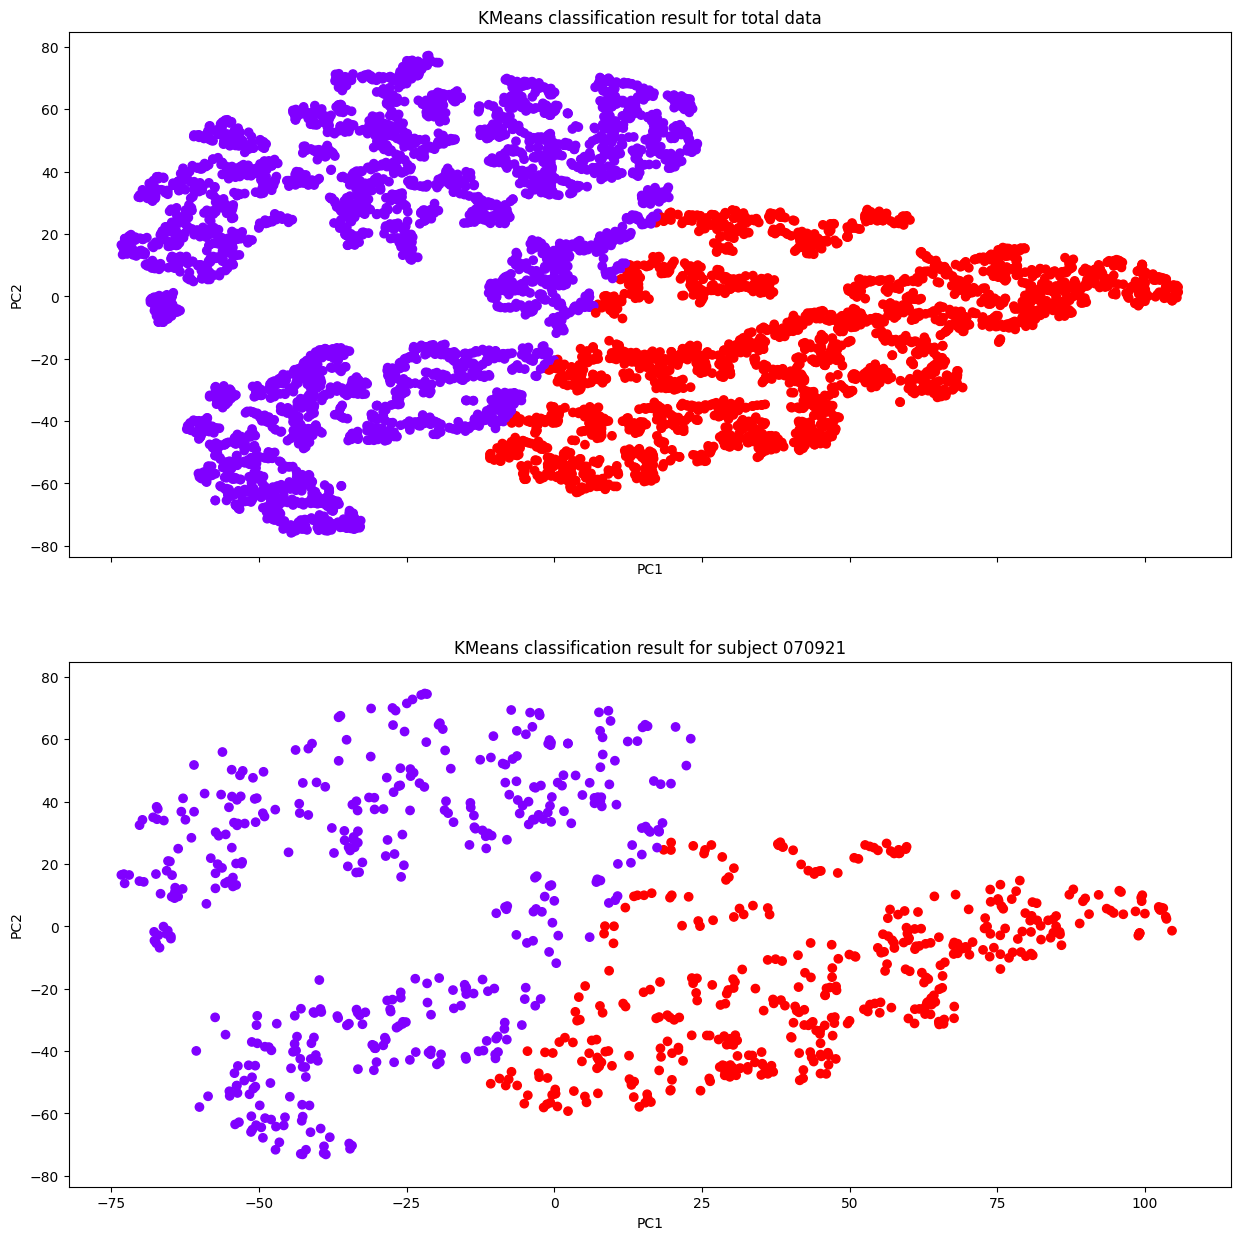

In [93]:
#extract numpy array from dataframe df with designated columns and subject default = 070921
#neglect the last two columns (subject and stimuli)
def extractNumpyArray(DF,lstColumnNames,subject):
    extractedDF = DF.loc[DF['Subject'] == subject]
    extractedDF = extractedDF.loc[:,lstColumnNames]
    return extractedDF


def classificationResultPlot(reducedSampleDF,lstColumnNames = ['PC1','PC2','label'] ,subject = '070921'):
    #extract reducedSampleDF
    extractedReducedSampleDF = extractNumpyArray(reducedSampleDF,lstColumnNames,subject)
    #plotting according to kmeans clustering classification result
    fig,axs = plt.subplots(2,1,sharex = True,sharey = True,figsize=(15,15))

    axs[0].scatter(reducedSampleDF['PC1'],reducedSampleDF['PC2'],c=reducedSampleDF['label'],cmap='rainbow')
    axs[0].set_xlabel('PC1')
    axs[0].set_ylabel('PC2')
    axs[0].set_title('KMeans classification result for total data')

    axs[1].scatter(extractedReducedSampleDF['PC1'],extractedReducedSampleDF['PC2'],c=extractedReducedSampleDF['label'],cmap='rainbow')
    axs[1].set_xlabel('PC1')
    axs[1].set_ylabel('PC2')
    axs[1].set_title('KMeans classification result for subject 070921')

    #plt.legend()
    plt.show()

    #plot according to subject

    #save figures
    fig.savefig('kmeans_2.png')

classificationResultPlot(reducedSampleDF)

In [94]:
#give number of datapoints in each cluster
def numberDatapointsInClusters(DF):
    #group by label
    groupedDF = DF.groupby('label')
    #count number of datapoints in each cluster
    countDF = groupedDF.count()
    return countDF

print(numberDatapointsInClusters(DF))

       duration  meanSpikingFreq  maxSpikingFreq  withinBurstSpikeNum  \
label                                                                   
0          3689             3689            3689                 3689   
1          2541             2541            2541                 2541   

       interBurst  withinBurstSpikePercentage  meanburstFreq  meanSurprise  \
label                                                                        
0            3689                        3689           3689          3689   
1            2541                        2541           2541          2541   

       maxSurprise  Subject  Neuron  Stimuli  
label                                         
0             3689     3689    3689     3689  
1             2541     2541    2541     2541  


In [98]:
def histoResults(DF,lstColumnNames,plotFunc,plotParams,saveFileName = 'histograms.jpg'):
    #3x3 subplots
    #fig,ax = plt.subplots(9,1,figsize=(15,15))
    fig = plt.figure(figsize=(15,15))
    #sns plot with hue of each of the nine parameters on a row for datapoints in each cluster
    for j in range(9):
        #use "y = " for barplot, "x = " otherwise
        #figure into the jth subplot
        fig.add_subplot(3,3,j+1)
        plotFunc(data=DF,y=lstColumnNames[j],**plotParams)

        #ax[j].set_title(f'cluster {lstColumnNames[j]}')

    plt.show()
    fig.savefig(saveFileName)
    return

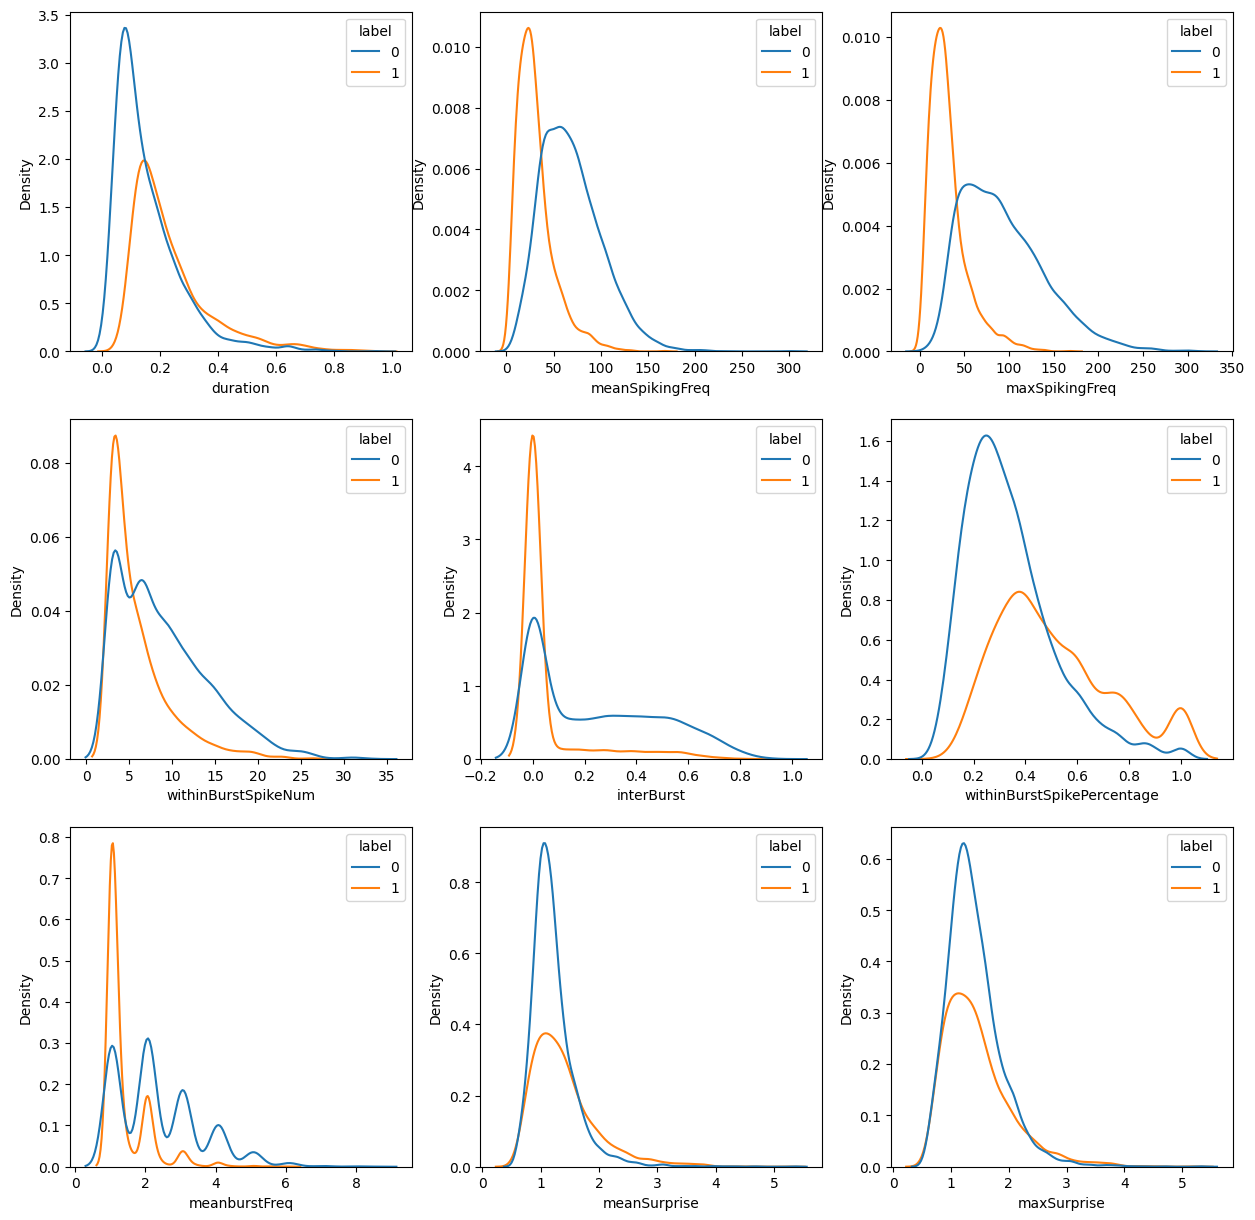

In [97]:
histoResults(DF,lstColumnNames,sns.kdeplot,{'hue':'label'},'kdeplot.jpg')

In [111]:
#concatenate 50 random samples from df1 and df2 
def concatRandomSamples(DF,numSamples,N = 2,randomState = 42,label = 'label'):
    #split dataframe by labels
    lstLabels = range(N)
    lstDF = ['']*len(lstLabels)
    for i in lstLabels:
        elementDF = DF.loc[DF[label] == i]
        #print(elementDF.shape)
        #randomly select 50 samples from each dataframe
        elementDF = elementDF.sample(n=numSamples,random_state = randomState)

        lstDF[i] = elementDF


    #concatenate dataframes
    df = pd.concat(lstDF,axis=0)
    return df

concatDF = concatRandomSamples(DF,2500)
print(concatDF)


      duration  meanSpikingFreq  maxSpikingFreq  withinBurstSpikeNum  \
2999    0.2821        70.896845      116.279070                   20   
3242    0.0855        46.783626       46.783626                    4   
4040    0.0683        43.923865       43.923865                    3   
4382    0.1638        79.365079      131.147541                   13   
3293    0.3211        77.857365      122.950820                   25   
...        ...              ...             ...                  ...   
4832    0.2338        17.108640       17.108640                    4   
4802    0.3196        40.675845       45.019696                   13   
1049    0.2881        10.413051       10.413051                    3   
4873    0.6510         6.144393        6.144393                    4   
4729    0.1721        52.295177       52.295177                    9   

      interBurst  withinBurstSpikePercentage  meanburstFreq  meanSurprise  \
2999      0.6729                    0.512821       5.02310

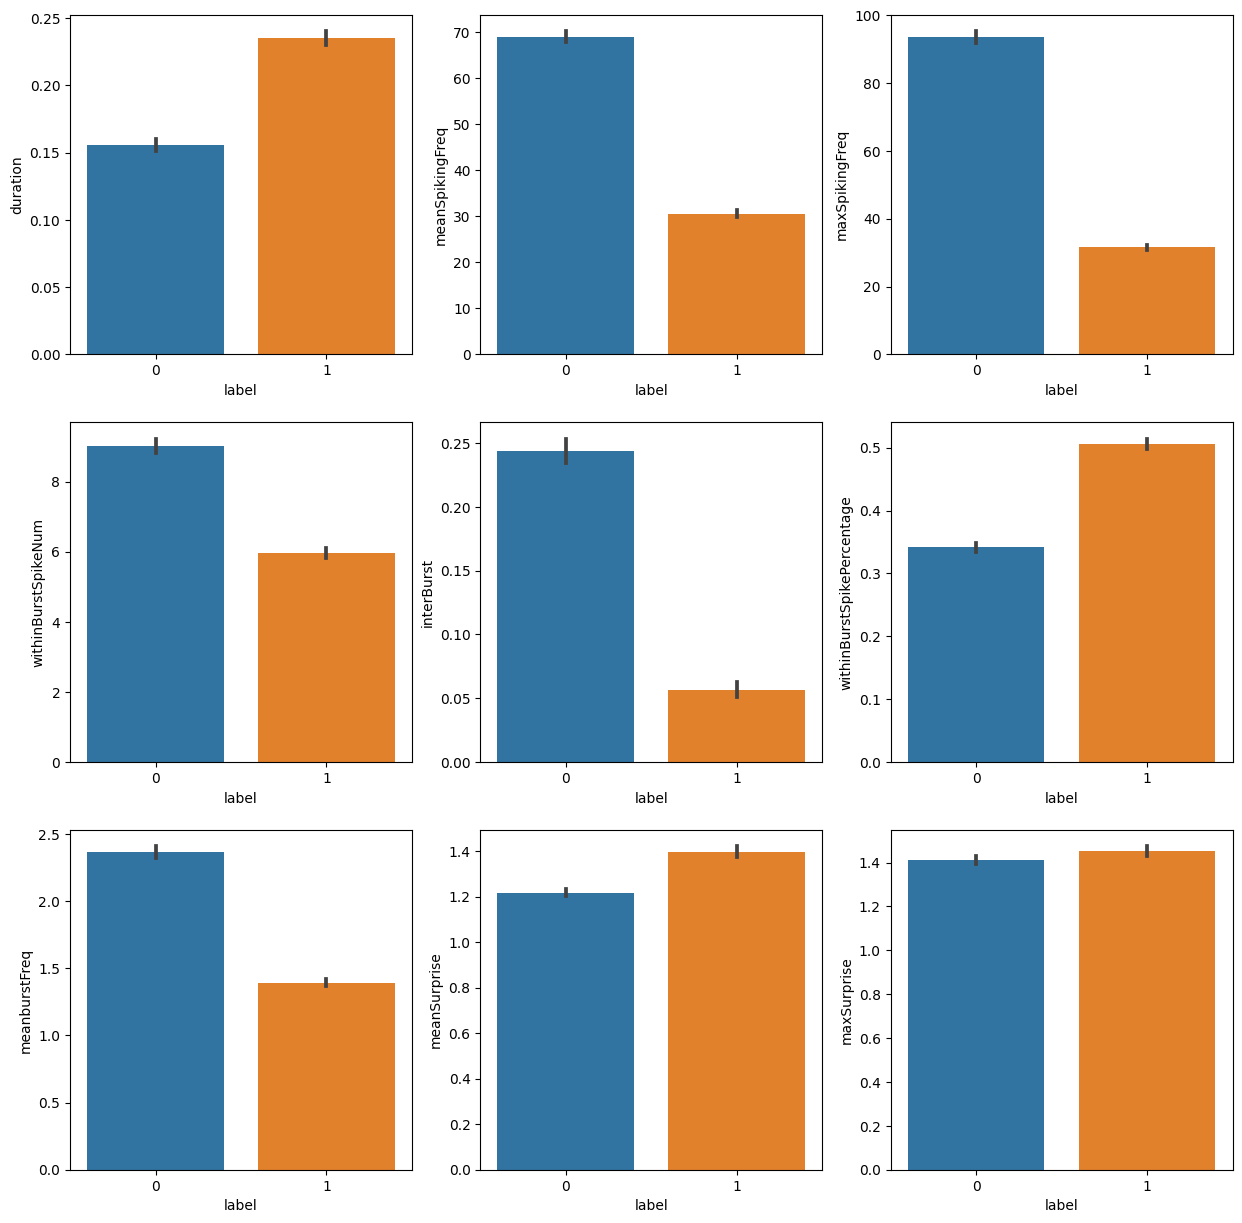

In [110]:
histoResults(concatDF,['duration','meanSpikingFreq','maxSpikingFreq','withinBurstSpikeNum',\
                       'interBurst','withinBurstSpikePercentage','meanburstFreq','meanSurprise','maxSurprise'],\
                        sns.barplot,{'x':'label'},'barplot_2_2500.jpg')